<a href="https://colab.research.google.com/github/dmitriiDr/Notebooks_ML/blob/main/Individual_Household_Electric_Power_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.**

# **Step 1: Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             root_mean_squared_error,
                             mean_absolute_error)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime

# **Step 2: Load the Dataset**

In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
X.head()

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
y = individual_household_electric_power_consumption.data.targets

In [6]:
print(y)

None


`Global_active_power`: Household global minute-averaged active power (in kilowatt)

`Global_reactive_power`: Household global minute-averaged reactive power (in kilowatt)

`Voltage`: Average voltage

`Sub_metering_1`: Energy sub-metering No. 1 (kitchen)

`Sub_metering_2`: Energy sub-metering No. 2 (laundry room)

`Sub_metering_3`: Energy sub-metering No. 3 (electric water heater and air-conditioning)


In [7]:
X.isnull().sum()

,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return tt.sort_values("Percent", ascending=False)

In [9]:
missing_data(X)

,Total,Percent
Sub_metering_3,25979,1.251844
Date,0,0.000000
Time,0,0.000000
Global_reactive_power,0,0.000000
Global_active_power,0,0.000000
Voltage,0,0.000000
Global_intensity,0,0.000000
Sub_metering_1,0,0.000000
Sub_metering_2,0,0.000000


In [10]:
X.dropna(inplace=True)

In [11]:
X['datetime'] = X['Date'] + ' ' + X['Time']
X.set_index('datetime', inplace=True)

In [12]:
X.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,,
16/12/2006 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
16/12/2006 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
16/12/2006 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [13]:
X.drop(['Date', 'Time'], axis=1, inplace=True)

In [14]:
X['Global_active_power'] = pd.to_numeric(X['Global_active_power'])

In [15]:
X.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
16/12/2006 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
16/12/2006 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
16/12/2006 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
16/12/2006 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [16]:
X.index = pd.to_datetime(X.index,dayfirst=True)

In [17]:
X.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [18]:
def is_numeric(X):
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    return X

In [19]:
X = is_numeric(X)

In [20]:
 missing_data(X)

,Total,Percent
Global_active_power,0,0.0
Global_reactive_power,0,0.0
Voltage,0,0.0
Global_intensity,0,0.0
Sub_metering_1,0,0.0
Sub_metering_2,0,0.0
Sub_metering_3,0,0.0


In [21]:
# Resample the data to daily averages
daily_data = X.resample('D').mean()

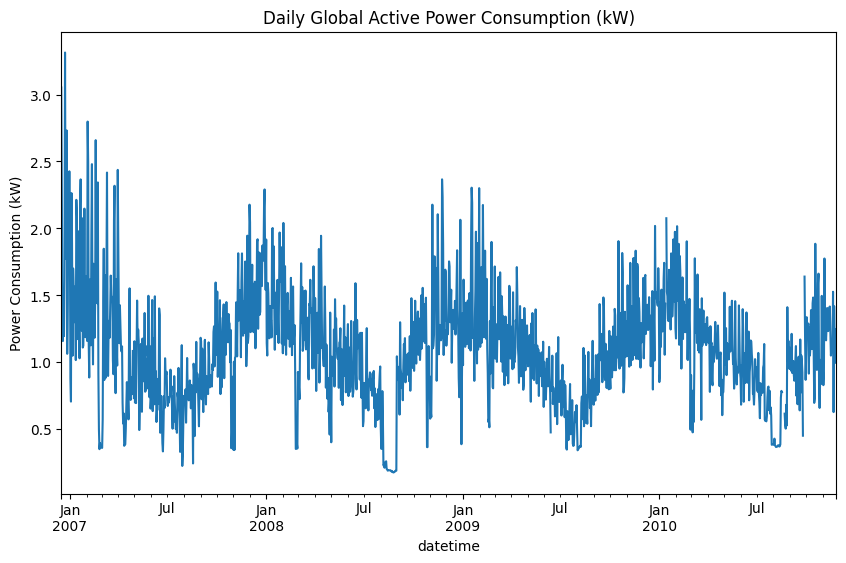

In [22]:
# Plot the time series
plt.figure(figsize=(10,6))
daily_data['Global_active_power'].plot(title="Daily Global Active Power Consumption (kW)")
plt.ylabel('Power Consumption (kW)')
plt.show()

# **Step 5: Train-Test Split for Time Series Data**

In [23]:
split_point = int(len(daily_data) * 0.8)
train = daily_data[:split_point]
test = daily_data[split_point:]

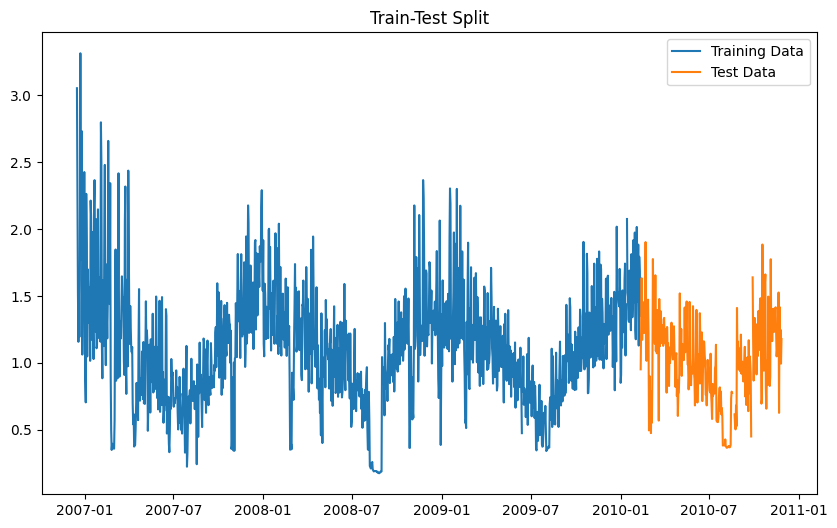

In [24]:
plt.figure(figsize=(10,6))
plt.plot(train['Global_active_power'], label='Training Data')
plt.plot(test['Global_active_power'], label='Test Data')
plt.title('Train-Test Split')
plt.legend();

In [25]:
from statsmodels.tsa.stattools import adfuller

In [26]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result, labels):
        print(f'{label}: {value}')
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

In [27]:
adf_test(train['Global_active_power'], title='Training Data')

Augmented Dickey-Fuller Test: Training Data
ADF Statistic: -3.0792943332965392
p-value: 0.028123933168119848
# Lags Used: 20
# Observations: 1129
=> The series is stationary.


In [28]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [29]:
# Define the time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [30]:
!pip install pmdarima scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.1 MB/s eta 0:00:00


In [31]:
from pmdarima import auto_arima

In [32]:
def sarima_cross_val_score(y):
    mse_list = []
    for train_index, test_index in tscv.split(y):
        train, test = y.iloc[train_index], y.iloc[test_index]

        # Fit AutoARIMA on the training set
        model = auto_arima(train,
                           start_p=0, start_q=0,
                           start_P=0, start_Q=0,
                           max_p = 3, max_q = 3,
                           d = None, D = None,
                           m=7,
                           seasonal=True, suppress_warnings=True)

        # Make predictions on the test set
        predictions = model.predict(n_periods=len(test))

        # Compute MSE for this fold
        mse = mean_squared_error(test, predictions)
        mse_list.append(mse)
    print(model.summary())
    print(f'Mean Squared Error: {np.mean(mse_list)}')
    return model

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

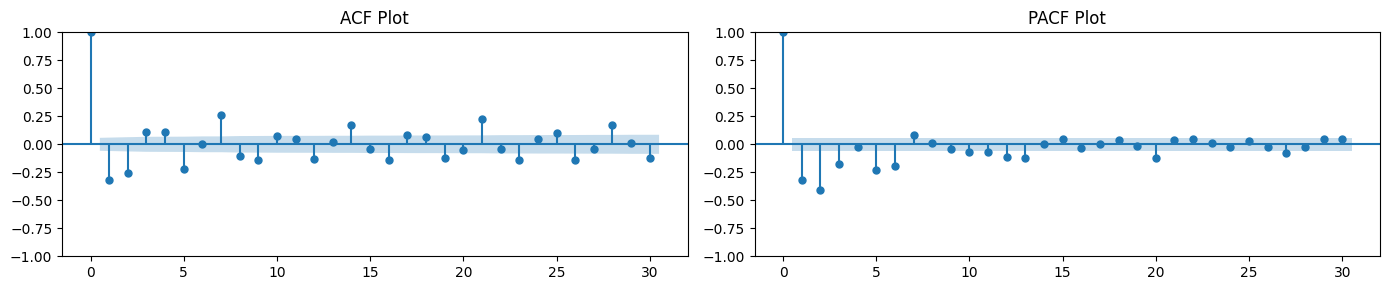

In [34]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(train.Global_active_power.diff().dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(train.Global_active_power.diff().dropna(), lags=30, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ACF Plot')

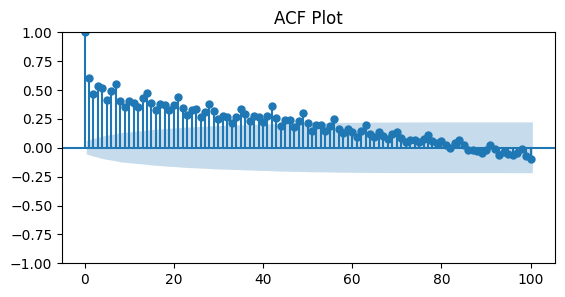

In [35]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(train.Global_active_power.dropna(), lags=100, ax=plt.gca())
plt.title('ACF Plot')

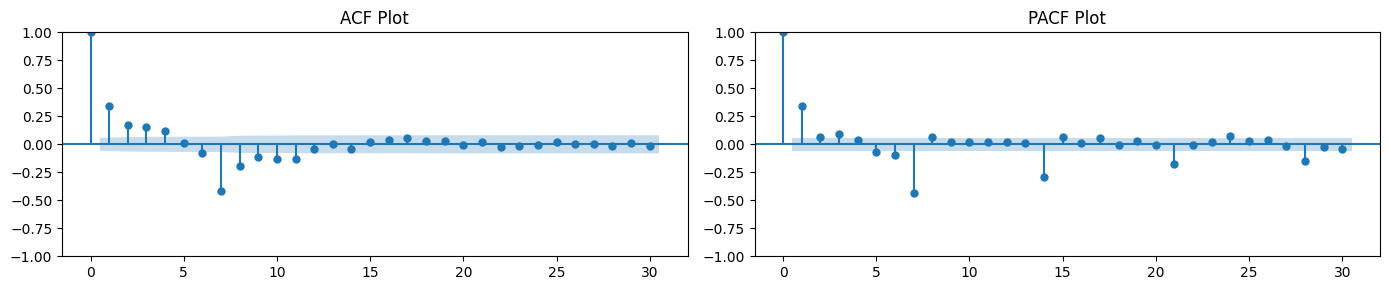

In [36]:
plt.figure(figsize=(14,3))

plt.subplot(121)
plot_acf(train.Global_active_power.diff(7).dropna(), lags=30, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(train.Global_active_power.diff(7).dropna(), lags=30, ax=plt.gca())
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [37]:
train_period = train.copy()
train_period.index = pd.PeriodIndex(train_period.index, freq='D')

In [38]:
train_period.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


In [39]:
model = auto_arima(train.Global_active_power.dropna(),
                   start_p=0, start_q=0,
                   start_P=0, start_Q=0,
                   max_p = 3, max_q = 3,
                   max_P = 2, max_Q = 2,
                   d = None, D = None,
                   m=7,
                   seasonal=True, suppress_warnings=True)

In [40]:
model.fit(train.Global_active_power.dropna())

ARIMA(order=(3, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [41]:
train.index

DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-02-01', '2010-02-02', '2010-02-03', '2010-02-04',
               '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08',
               '2010-02-09', '2010-02-10'],
              dtype='datetime64[ns]', name='datetime', length=1153, freq='D')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


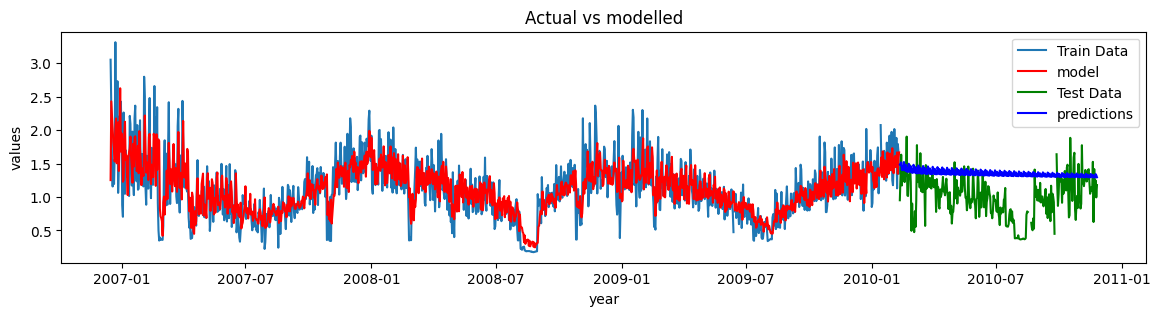

In [42]:
plt.figure(figsize=(14,3))
plt.plot(train.Global_active_power, label='Train Data')
plt.plot(model.fittedvalues().index, model.fittedvalues(), label='model', color='red')
plt.plot(test.Global_active_power.index, test.Global_active_power, label='Test Data', color='green')
plt.plot(test.Global_active_power.index, model.predict(len(test)), label = 'predictions', color='blue')
plt.legend()
plt.title('Actual vs modelled')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

In [43]:
from pmdarima.arima import ARIMA
p, d, q = 3, 0, 2
model_2 = ARIMA((p,d,q), seasonal_order=(0,0,2,7))

In [44]:
from pandas import date_range

In [45]:
train_index = train.copy()

In [46]:
train_index.index = pd.PeriodIndex(train_index.index, freq='D')

In [47]:
train_index.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


In [48]:
model_2.fit(train_index.Global_active_power.dropna())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(3, 0, 2), seasonal_order=(0, 0, 2, 7))

In [49]:
print(model_2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1150
Model:             SARIMAX(3, 0, 2)x(0, 0, 2, 7)   Log Likelihood                -290.179
Date:                           Wed, 30 Oct 2024   AIC                            598.359
Time:                                   08:59:33   BIC                            643.786
Sample:                               12-16-2006   HQIC                           615.507
                                    - 02-10-2010                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0602      0.020      3.081      0.002       0.022       0.098
ar.L1          0.8397      0.164      5.123

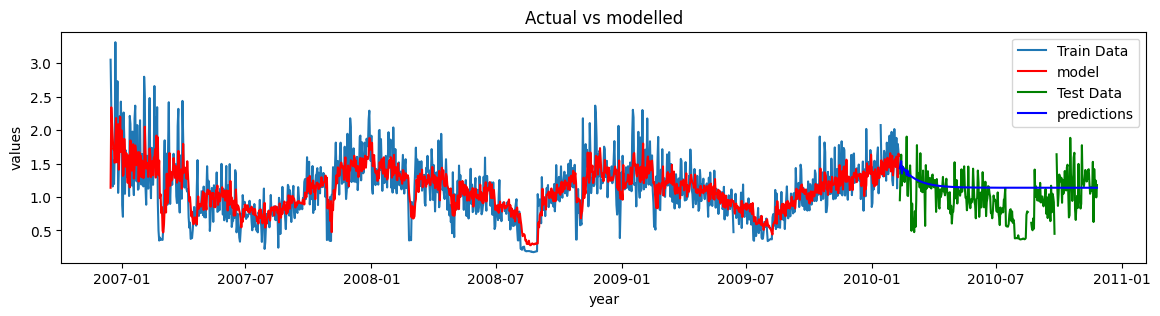

In [50]:
plt.figure(figsize=(14,3))
plt.plot(train.Global_active_power, label='Train Data')
plt.plot(model_2.fittedvalues().index, model_2.fittedvalues(), label='model', color='red')
plt.plot(test.Global_active_power.index, test.Global_active_power, label='Test Data', color='green')
plt.plot(test.Global_active_power.index, model_2.predict(len(test)), label = 'predictions', color='blue')
plt.legend()
plt.title('Actual vs modelled')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

In [51]:
model_3 = ARIMA((3, 0, 1), seasonal_order=(1, 0, 1, 7))
model_3.fit(train_index.Global_active_power.dropna())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(order=(3, 0, 1), seasonal_order=(1, 0, 1, 7))

In [52]:
print(model_3.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1150
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 7)   Log Likelihood                -245.780
Date:                           Wed, 30 Oct 2024   AIC                            507.560
Time:                                   08:59:36   BIC                            547.941
Sample:                               12-16-2006   HQIC                           522.803
                                    - 02-10-2010                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0034      0.002      2.179      0.029       0.000       0.006
ar.L1          0.8629      0.071     12.192

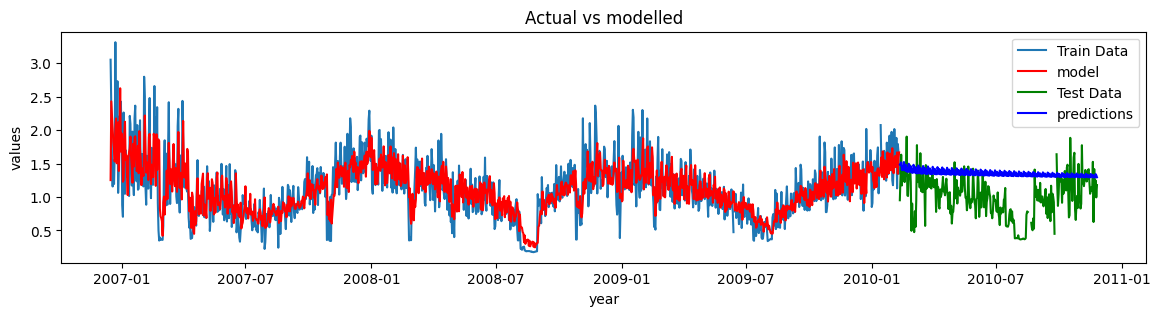

In [53]:
plt.figure(figsize=(14,3))
plt.plot(train.Global_active_power, label='Train Data')
plt.plot(model_3.fittedvalues().index, model_3.fittedvalues(), label='model', color='red')
plt.plot(test.Global_active_power.index, test.Global_active_power, label='Test Data', color='green')
plt.plot(test.Global_active_power.index, model_3.predict(len(test)), label = 'predictions', color='blue')
plt.legend()
plt.title('Actual vs modelled')
plt.xlabel('year')
plt.ylabel('values')
plt.show()

trying another model

In [54]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)

    return np.array(X), np.array(y)

In [55]:
features, target = df_to_X_y(X.Global_active_power, 7)

In [56]:
features.shape, target.shape

((2049273, 7, 1), (2049273,))

In [57]:
def train_split(X, y):
    split_point = int(len(X) * 0.8)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    return X_train, X_test, y_train, y_test

In [58]:
features_train, features_test, target_train, target_test = train_split(features, target)

In [59]:
training_mean = np.mean(features_train[:,:,0])
training_std = np.std(features_train[:,:,0])

def preprocess(X):
    X[:,:,0] = X[:,:,0] - training_mean / training_std

    return X

In [60]:
preprocess(features_train)
preprocess(features_test)

array([[[-0.67386583],
        [-0.67586583],
        [-0.67186583],
        ...,
        [-0.67186583],
        [-0.59586583],
        [-0.47186583]],

       [[-0.67586583],
        [-0.67186583],
        [-0.67186583],
        ...,
        [-0.59586583],
        [-0.47186583],
        [-0.48786583]],

       [[-0.67186583],
        [-0.67186583],
        [-0.67186583],
        ...,
        [-0.47186583],
        [-0.48786583],
        [-0.48786583]],

       ...,

       [[-0.07186583],
        [-0.06986583],
        [-0.06986583],
        ...,
        [-0.06986583],
        [-0.06986583],
        [-0.07186583]],

       [[-0.06986583],
        [-0.06986583],
        [-0.07386583],
        ...,
        [-0.06986583],
        [-0.07186583],
        [-0.07786583]],

       [[-0.06986583],
        [-0.07386583],
        [-0.06986583],
        ...,
        [-0.07186583],
        [-0.07786583],
        [-0.08186583]]])

In [61]:
from keras import layers
from keras import Sequential
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.metrics import RootMeanSquaredError

In [62]:
features_train.shape

(1639418, 7, 1)

In [63]:
model3 = Sequential([

    layers.InputLayer((7,1)),
    layers.Conv1D(64, kernel_size=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(8, 'relu'),
    layers.Dense(1, 'linear')
])

model3.summary()

cp3 = ModelCheckpoint('model3/.keras',save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model3.fit(features_train,target_train,validation_data=(features_test, target_test), epochs=10, callbacks=[cp3])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 6, 64)               │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           3,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,281 (12.82 KB)

 Trainable params: 3,281 (12.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - loss: 0.1170 - root_mean_squared_error: 0.3249 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2174
Epoch 2/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 137s 2ms/step - loss: 0.0716 - root_mean_squared_error: 0.2675 - val_loss: 0.0478 - val_root_mean_squared_error: 0.2185
Epoch 3/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 111s 2ms/step - loss: 0.0713 - root_mean_squared_error: 0.2670 - val_loss: 0.0471 - val_root_mean_squared_error: 0.2170
Epoch 4/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 142s 2ms/step - loss: 0.0701 - root_mean_squared_error: 0.2649 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2192
Epoch 5/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 107s 2ms/step - loss: 0.0691 - root_mean_squared_error: 0.2629 - val_loss: 0.0458 - val_root_mean_squared_error: 0.2141
Epoch 6/10
51232/51232 ━━━━━━━━━━━━━━━━━━━━ 143s 2ms/step - loss: 0.0686 - root_mean_squared_error: 0.2620 - val_loss: 0.0451 - val_root_mean_squared_error: 0.2124
Epoch 7/10
51232

In [66]:
def plot_predictions(model, X, y, start=0, end=100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':predictions,
                       'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.legend(['Predicted','Real'])

    return df, mean_squared_error(y, predictions)

12808/12808 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


(        Predictions  Actuals
 0          0.636737    0.528
 1          0.512694    0.528
 2          0.554097    0.522
 3          0.534651    0.532
 4          0.558162    0.514
 ...             ...      ...
 409850     0.955796    0.946
 409851     0.953579    0.944
 409852     0.950341    0.938
 409853     0.942418    0.934
 409854     0.941004    0.932
 
 [409855 rows x 2 columns],
 0.04496097905896404)

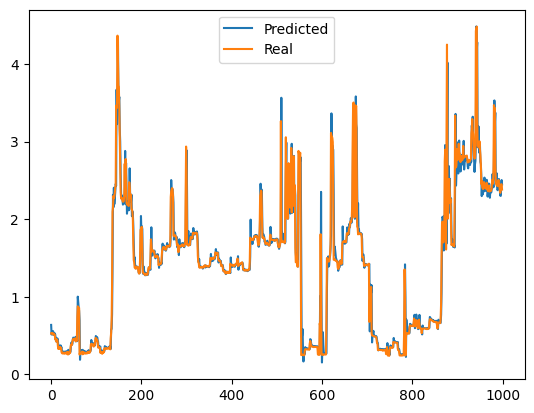

In [67]:
plot_predictions(model3, features_test, target_test, 0, 1000)